# CIFAR 100 using Transfer Learning (Inceptionv3)

# Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,BatchNormalization,GlobalAveragePooling2D,UpSampling2D

# Importing the Cifar 100 Dataset


In [3]:
cifar10 = tf.keras.datasets.cifar100
(X_train, Y_train), (X_test,Y_test) = cifar10.load_data()

# Plotting some images

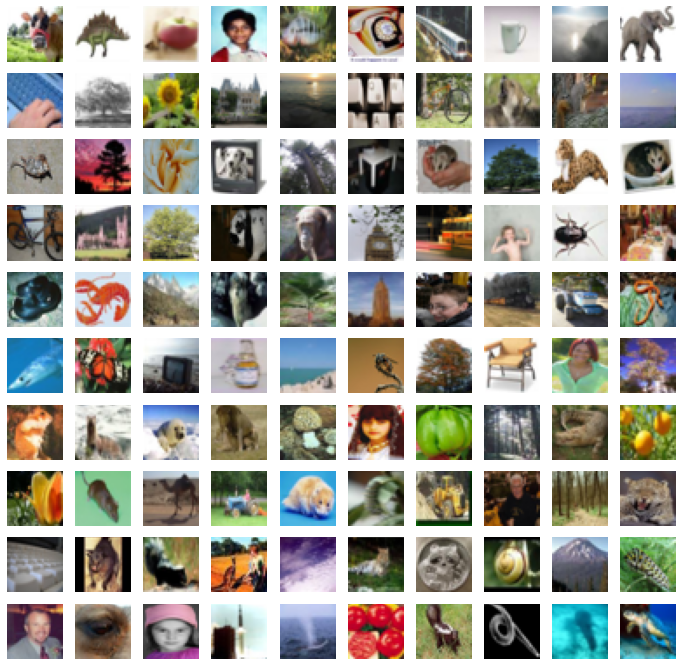

In [4]:
plt.figure(figsize=(12,12))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(X_train[i],cmap='gray')

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(X_train, Y_train,test_size=0.2)

# Onehot encoding of the outputs


In [6]:
from keras.utils.np_utils import to_categorical
y_train=to_categorical(y_train,num_classes=100)
y_val=to_categorical(y_val,num_classes=100)
y_test=to_categorical(Y_test,num_classes=100)

In [7]:
x_train = x_train*1.0/255
x_val = x_val*1.0/255
X_test = X_test*1.0/255

In [8]:
print(x_train.shape,x_val.shape,X_test.shape)
print(y_train.shape,y_val.shape,y_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 100)


# Image Data Augmentation

In [9]:
train_datagen = ImageDataGenerator( 
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1,  
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,  
        vertical_flip = False
        )
train_datagen.fit(x_train)

# Reduce Learning Rate if accuracy is not improving for 3 epochs

In [10]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.6, 
    min_lr=1e-6)

# Importing the Inceptionv3 Model

In [11]:
from tensorflow.keras.applications import InceptionV3
inception_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

for layer in inception_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
model=tf.keras.models.Sequential()
model.add(UpSampling2D(size=(7, 7),interpolation='bilinear'))
model.add(inception_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))


In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

In [15]:
model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
result=model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 128),
    validation_data = (x_val, y_val),
    epochs = 60,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)


Epoch 1/60
313/313 [==============================] - 109s 350ms/step - loss: 1.4055 - accuracy: 0.6101 - val_loss: 1.2785 - val_accuracy: 0.6424
Epoch 2/60
313/313 [==============================] - 110s 350ms/step - loss: 1.3931 - accuracy: 0.6137 - val_loss: 1.2614 - val_accuracy: 0.6489
Epoch 3/60
313/313 [==============================] - 110s 350ms/step - loss: 1.3680 - accuracy: 0.6166 - val_loss: 1.2479 - val_accuracy: 0.6487
Epoch 4/60
313/313 [==============================] - 110s 350ms/step - loss: 1.3585 - accuracy: 0.6240 - val_loss: 1.2462 - val_accuracy: 0.6516
Epoch 5/60
313/313 [==============================] - 110s 350ms/step - loss: 1.3294 - accuracy: 0.6288 - val_loss: 1.2237 - val_accuracy: 0.6555
Epoch 6/60
313/313 [==============================] - 110s 350ms/step - loss: 1.3221 - accuracy: 0.6278 - val_loss: 1.2127 - val_accuracy: 0.6589
Epoch 7/60
313/313 [==============================] - 110s 350ms/step - loss: 1.3084 - accuracy: 0.6339 - val_loss: 1.2003 -

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) (None, None, None, None)  0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization_94 (Batc (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2

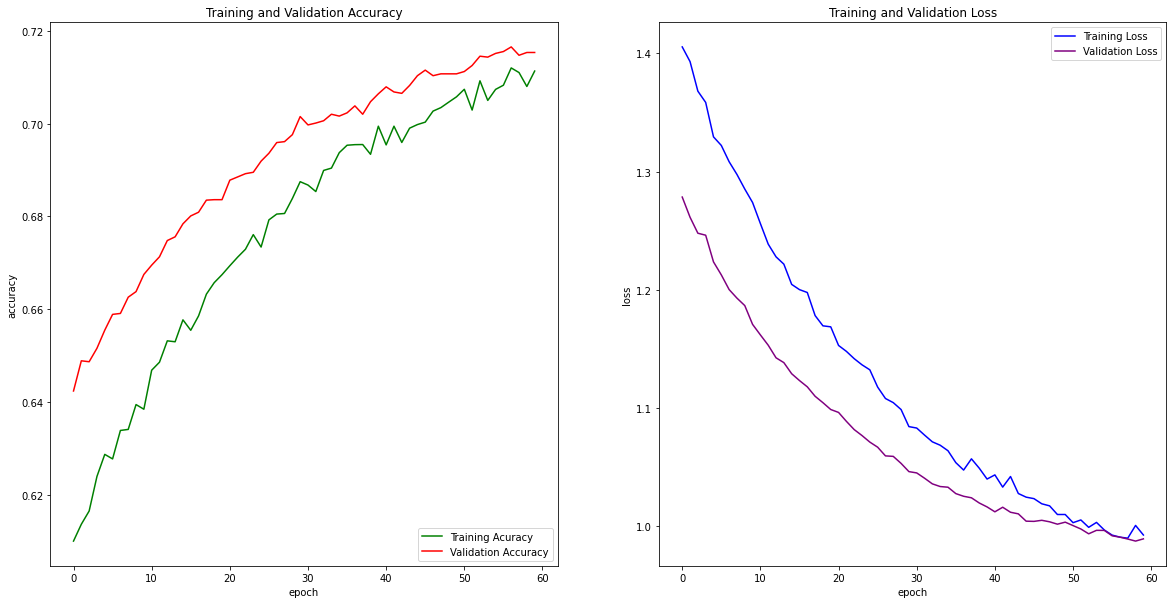

In [21]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']
loss = result.history['loss']
val_loss = result.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("Training and Validation Accuracy")
plt.plot(acc,color = 'green',label = 'Training Acuracy')
plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.subplot(1, 2, 2)
plt.title('Training and Validation Loss')
plt.plot(loss,color = 'blue',label = 'Training Loss')
plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

# Predictions,Accuracy and Confusion Matrix

In [22]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = Y_test.ravel()
print(y_pred.shape,y_true.shape)

(10000,) (10000,)


In [25]:
from sklearn.metrics import accuracy_score,confusion_matrix

print("Testing Accuracy: ", accuracy_score(y_true,y_pred))

Testing Accuracy:  0.7129


In [26]:
cm = confusion_matrix(y_true,y_pred)
cm

array([[94,  0,  0, ...,  0,  0,  0],
       [ 0, 73,  0, ...,  0,  0,  0],
       [ 0,  0, 64, ...,  0,  7,  0],
       ...,
       [ 0,  0,  0, ..., 72,  0,  0],
       [ 0,  0, 10, ...,  0, 50,  0],
       [ 0,  0,  0, ...,  0,  0, 77]])